# Regression Analysis: Predicting Ames Housing Market Prices

<br>

Housing prices have steadily increased over the course of the past three decades with the exception of severe economic downturns such as the economic recession of 2008. 
The housing market is not only a very strong economic indicator but it has a financial impact on anyone looking to own a home themselves. 
To better understand the effects that individual factors have on the housing prices, I am interested in using supervised learning techniques to model housing prices.
By using machine learning techniques to do this the process can be automated to include a large amount of data points and different trends can be detected that may not be readily apparent to humans.


In this study, several types of supervised learning classification models were used to predict housing prices in Ames, Iowa. Models focused on utilizing multiple housing price indicators, including factors related to the size and location of the living spaces. The different models were compared to better understand their ability to utilize the data to accurately predict the housing market using multiple forms of statistical evaluation. The process used to undertake this study is as follows:

<br>

Initiation and Data Preprocessing
* Importing Packages and Files
* Defining Reusable Functions
* Data Exploration and Cleaning

Exploratory Data Analysis
* Identifying Statistically Significant Features
* Univariate, Bivariate, and Multivariate Analysis
* Analyzing the Relationship Between the Variables
* Descriptive Statistics and Boxplots

Predictive Modeling and Evaluation
* Data Preprocessing
* Lasso Regression
* Elastic Net Regression
* Random Forests
* Gradient Boost
* Creating Price Predictions


## Initiation and Data Preprocessing


### Importing Packages and Files

In [1]:
%%time

## import packages

import warnings

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from feature_engine import outlier_removers as outr
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector
from sklearn.feature_selection import f_regression, SelectKBest, chi2, mutual_info_regression

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

sns.set_style('darkgrid')
sns.color_palette('Paired')

# Suppress Warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

CPU times: user 1.49 s, sys: 355 ms, total: 1.84 s
Wall time: 1.48 s


In [2]:
%%time

## import files

# read files
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

# saving multiple copies of training dataset
df_train = df_train_raw.copy()
df_train_plot = df_train_raw.copy()

CPU times: user 39.1 ms, sys: 8.53 ms, total: 47.7 ms
Wall time: 47 ms


### Defining Reusable Functions

In [3]:
%%time

## defining reusable functions

# create a function to analyze columns

def feature_analysis(dataframe):
    
    # include a column for dtypes of each feature
    feature_analysis_df = pd.DataFrame(dataframe.dtypes)
    feature_analysis_df.columns = ['dtypes']
    
    # include a column for number of unique values of each feature
    feature_analysis_df['nunique'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'nunique'] = len(dataframe.loc[:,feat].unique())
        
    # include a column for number of unique values of each feature    
    feature_analysis_df['isnull'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'isnull'] = dataframe.loc[:,feat].isnull().sum(axis = 0)
        
    # print dataset characteristics
    print('\nDataset Characteristics \n')
    print('rows:', dataframe.shape[0])
    print('columns:', dataframe.shape[1])
    print(feature_analysis_df)
    print()    
    
# a function to calculate rmse for model evaluation

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs


In [4]:
%%time

## defining reusable pipeline components 

# drop features with large amounts of null values features

def drop_select_features(dataframe):
    return dataframe.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'MiscFeature'],1)

drop_features = FunctionTransformer(drop_select_features)

# impute null values with string denoting missingness

def impute_null_categorical_values(dataframe):
    return dataframe.fillna('unknown')

impute_null_categorical = FunctionTransformer(impute_null_categorical_values)

# continuous features

def select_continuous_features(dataframe):
    return dataframe[list(dataframe.columns[dataframe.dtypes == 'int64'])]

continuous_features = FunctionTransformer(select_continuous_features)

# categorical features

def select_categorical_features(dataframe):
    return dataframe[list(dataframe.columns[dataframe.dtypes != 'int64'])]

categorical_features = FunctionTransformer(select_categorical_features)

# a custom transformer to pass unchanged features through a pipeline

def identity_transformer(dataframe):
    return dataframe

identity = FunctionTransformer(identity_transformer)

# a custom transformer to change a numpy matrix into a dataframe in a pipeline

def make_dataframe(dataframe):
    return pd.DataFrame(dataframe)

dataframe = FunctionTransformer(make_dataframe)

# create transformer function to add .0001 to all values

def make_non_zero(dataframe):
    return pd.DataFrame(dataframe).applymap(lambda x: x + .0001)

non_zero = FunctionTransformer(make_non_zero)

# create transformer function to one hot encode dataframes

def make_one_hot(dataframe):
    return pd.get_dummies(dataframe)

one_hot = FunctionTransformer(make_one_hot)

# create transformer to label one hot features

def label_categorical_features(dataframe):
    
    output = pd.DataFrame()
    
    for name in dataframe.columns:
        
        output[name] = dataframe[name].apply(lambda x: name + ' ' + str(x))
        
    return output

label_categorical = FunctionTransformer(label_categorical_features)

CPU times: user 24 µs, sys: 1 µs, total: 25 µs
Wall time: 27.2 µs


### Data Exploration and Cleaning

#### Checking for Correct Data Types

In [5]:
%%time

## display dataset characteristics

#feature_analysis(df_train_raw)

## split raw dataset for field-specific data cleaning

# continuous variables
df_train_raw_continuous = df_train_raw[list(df_train_raw.columns[df_train_raw.dtypes != 'object'])
                                      ].drop('SalePrice',1)

# categorical variables
df_train_raw_categorical = df_train_raw[list(df_train_raw.columns[df_train_raw.dtypes == 'object'])]

# target variable
df_train_raw_target = df_train_raw['SalePrice']

print()
print('Continuous Features:')
display(df_train_raw_continuous.columns)
print()
print('Categorical Features:')
display(df_train_raw_categorical.columns)
print()
print('Target Variable:')
display(df_train_raw['SalePrice'].name)
print()



Continuous Features:


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


Categorical Features:


Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


Target Variable:


'SalePrice'


CPU times: user 11.3 ms, sys: 3.61 ms, total: 14.9 ms
Wall time: 12.5 ms


The type of data contained within each feature is shown above. The target variable, sale price, contains continuous data.

#### Visualizing Missing Values


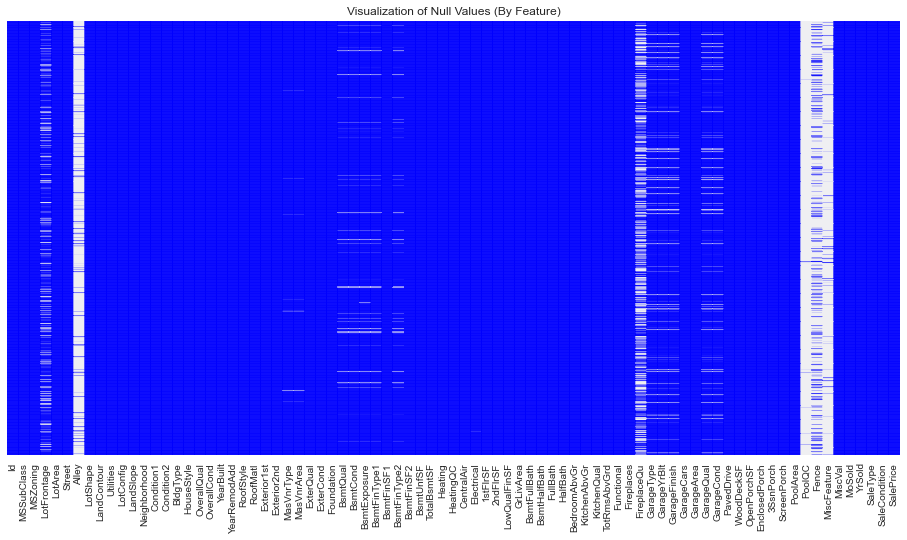

CPU times: user 3.99 s, sys: 421 ms, total: 4.41 s
Wall time: 4.22 s


In [6]:
%%time

## check for null values

#feature_analysis(df_train_raw_continuous)
#feature_analysis(df_train_raw_categorical)

## visualizing the prescence of null values

cmap=sns.color_palette("light:b_r")

fig, ax = plt.subplots(figsize=(16,8))         
ax = sns.heatmap(df_train_plot.isnull(), cbar=False, cmap=cmap, alpha=.5)
ax.set_title('Visualization of Null Values (By Feature)')
ax.set_yticks([])
plt.show()

The white spaces above the feature names in the visualization represent represent areas where the data is missing. An overwhelming amount of null values were found among the following features: 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', and 'MiscFeature'. These features will need to be dropped prior to modeling. Null values among the remaining features can be reliably imputed.

## Exploratory Data Analysis

Dataset used for this study includes information about home purchases in Ames pertaining to their physical qualities and how they were sold. Such information includes: the location of the homes, the spatial dimensions of the homes, and the methods in which the homes were sold.

### Analyzing the Distribution of the Target Variable

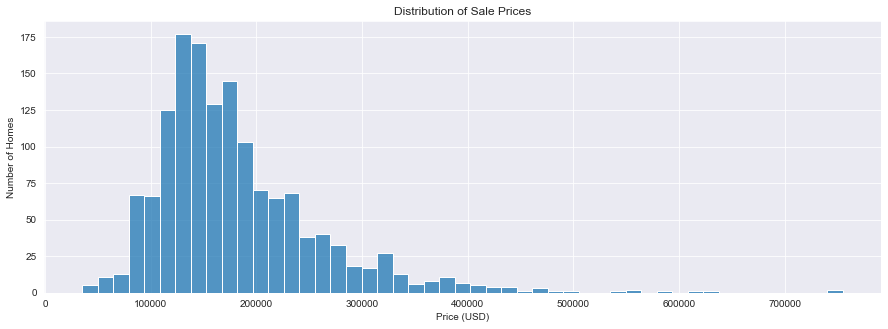

In [7]:

## ploting the distribution of the target variable

plt.figure(figsize=(15,5))
ax = sns.histplot(x='SalePrice', data=df_train_plot)
ax.set_title('Distribution of Sale Prices')
ax.set_xlabel('Price (USD)')
ax.set_ylabel('Number of Homes')
plt.show()

The mean sale price is \\$180,921 and the median sale price is \\$163,000. The distribution of the sale prices is skewed to the right. A logarithmic transformation can be used to make the sale prices more normally distributed prior to modeling.

### Identifying Statistically Significant Features

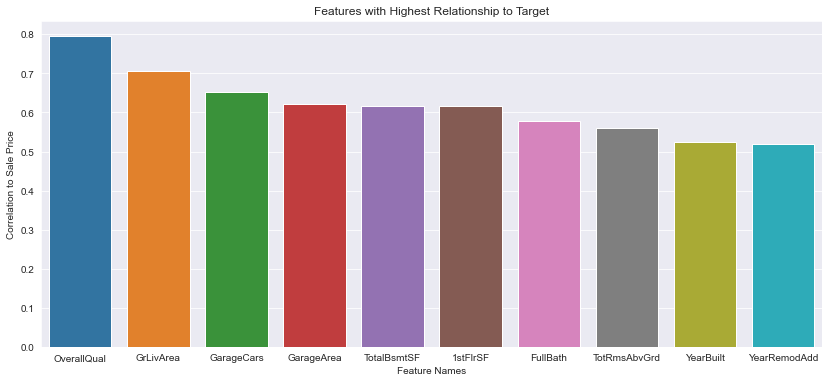

In [8]:

## analyzing continuous variables

# isolating continuous variables
df_train_plot = drop_select_features(df_train_raw).dropna()

df_train_continuous_plot = df_train_plot[list(df_train_plot.columns[df_train_plot.dtypes != 'object'])]

# identifying continuous variables with highest relationship to the target

# calculating p-values
continuous_pvalues = SelectKBest(score_func=f_regression, k='all').fit(
    df_train_continuous_plot.drop('SalePrice',1), df_train_continuous_plot['SalePrice']).pvalues_

# calculating correlation
continuous_correlation = abs(df_train_continuous_plot.corr()['SalePrice'])

# displaying relationship of features to target (sorted by ascending p-values)
print()

relationship_to_target = pd.DataFrame([df_train_continuous_plot.columns, 
                                       continuous_pvalues, continuous_correlation
                                      ]).T.rename({0:'feature name', 
                                                   1:'p-value', 
                                                   2:'correlation'}, axis=1
                                                 ).sort_values(by='p-value')

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax = sns.barplot(x="feature name", 
                 y="correlation", 
                 data=relationship_to_target.iloc[0:10,:])
ax.set_title('Features with Highest Relationship to Target')
ax.set_xlabel('Feature Names')
ax.set_ylabel('Correlation to Sale Price')

plt.show()


The above plot displays the ten continuous features with the highest linear relationship to the sales price. The units used to describe this is the absolute value of the correlation coefficient (range 0 to 1). Variables with a correlation coefficient of .5 or higher have a strong linear relationship with the sales price (variables with lower correlation coefficients are not shown here).

### Univariate Data Analysis

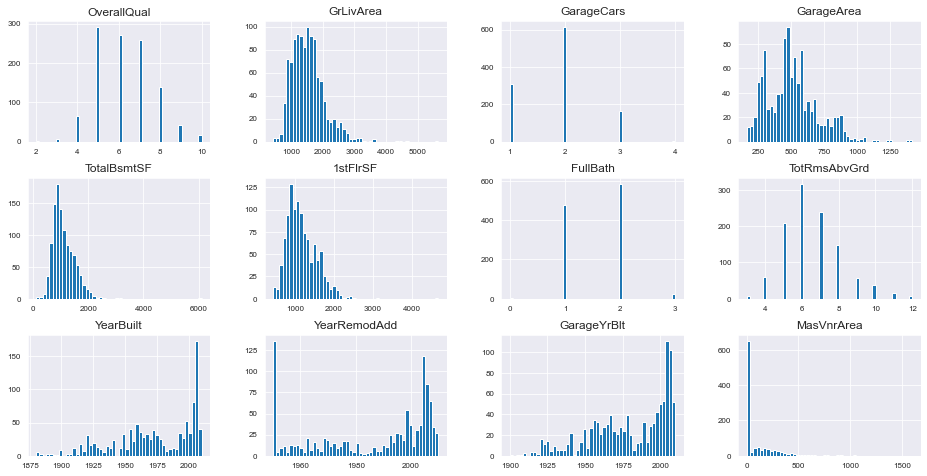

In [9]:

## visualizing the distribution of continuous variables

df_train_plot[relationship_to_target['feature name'][:12]
             ].hist(figsize=(16,8), 
                    bins=50, 
                    xlabelsize=8, 
                    ylabelsize=8, 
                    layout=(3,4))
plt.show()

The above histograms display the distribution of the top features. The histograms are ordered based on the features' correlation to the sale price (most correlated to least correlated). As the correlation decreases, the distribution of the features have less of a resemblance to the distribution of the sale price.

### Bivariate Data Analysis

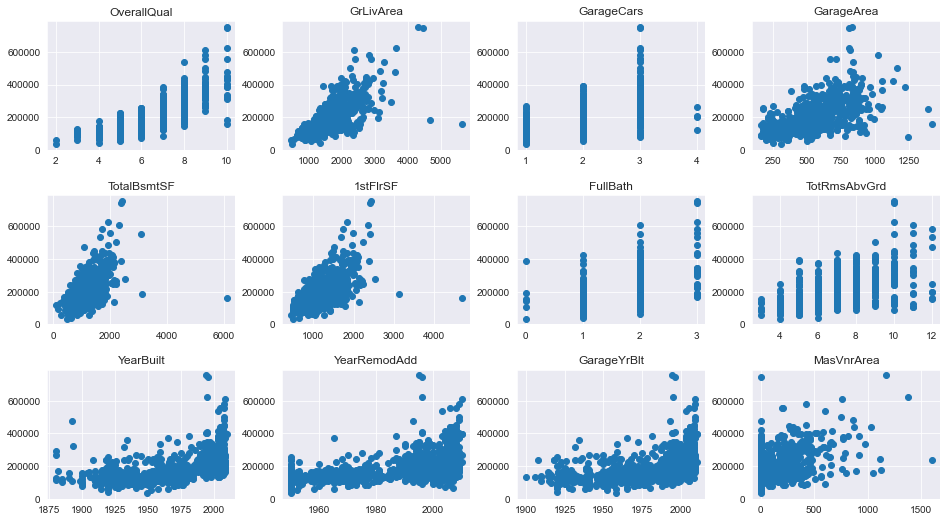

In [10]:

## visualizing the features' relationship to the target variable

# defining data to plot
df_to_plot = df_train_plot[relationship_to_target['feature name'][:12]]
target_to_plot = df_train_plot['SalePrice']

# defining plot dimensions
num_cols = 4
hspace = 0.35
wspace = 0.25
figsize = (16,12)

# plotting data
num_rows = len(df_to_plot.columns) // num_cols + 1

fig = plt.figure(figsize=figsize)
fig.subplots_adjust(hspace=hspace, wspace=wspace)

for i in range(len(df_to_plot.columns) + 1)[1:]:
    plt.subplot(num_rows, num_cols, i)
    plt.scatter(df_train_plot[df_to_plot.columns[i-1]],
                target_to_plot)
    plt.title(df_to_plot.columns[i-1])

The above scatterplots display the relationship of the top features to the sale price. The scatterplots are ordered based on the features' correlation to the sale price (most correlated to least correlated). As the correlation decreases, features display less of a linear relationship with sales price.

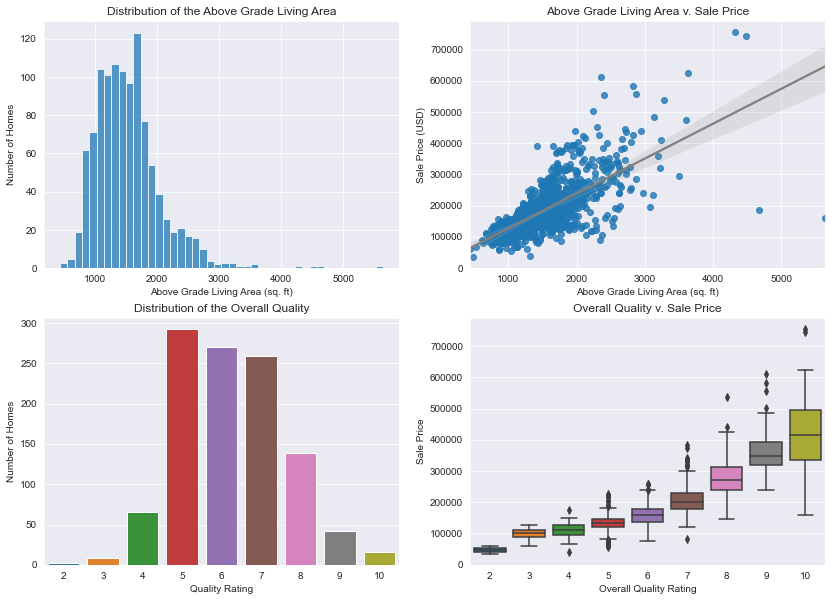

In [11]:

## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(1,2, figsize=(14,10))

# potting the distribution of the above grade living area of the homes
plt.subplot(2, 2, 1)
ax[0] = sns.histplot(x='GrLivArea', data=df_train_plot)
ax[0].set_title('Distribution of the Above Grade Living Area')
ax[0].set_xlabel('Above Grade Living Area (sq. ft)')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 2, 2)
ax[1] = sns.regplot(data=df_train_plot, x="GrLivArea", y="SalePrice",line_kws={'color':'grey'} )
ax[1].set_title('Above Grade Living Area v. Sale Price')
ax[1].set_xlabel('Above Grade Living Area (sq. ft)')
ax[1].set_ylabel('Sale Price (USD)')

# potting the distribution of the overall quality of the homes
plt.subplot(2, 2, 3)
ax[0] = sns.countplot(x='OverallQual', data=df_train_plot)
ax[0].set_title('Distribution of the Overall Quality')
ax[0].set_xlabel('Quality Rating')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 2, 4)
ax[1] = sns.boxplot(data=df_train_plot, x="OverallQual", y="SalePrice" )
ax[1].set_title('Overall Quality v. Sale Price')
ax[1].set_xlabel('Overall Quality Rating')
ax[1].set_ylabel('Sale Price')

plt.show()

There are a couple of outliers with abnormally high above grade living area but low sale prices (see top right scatter plot).

### Multivariate Analysis of Key Features

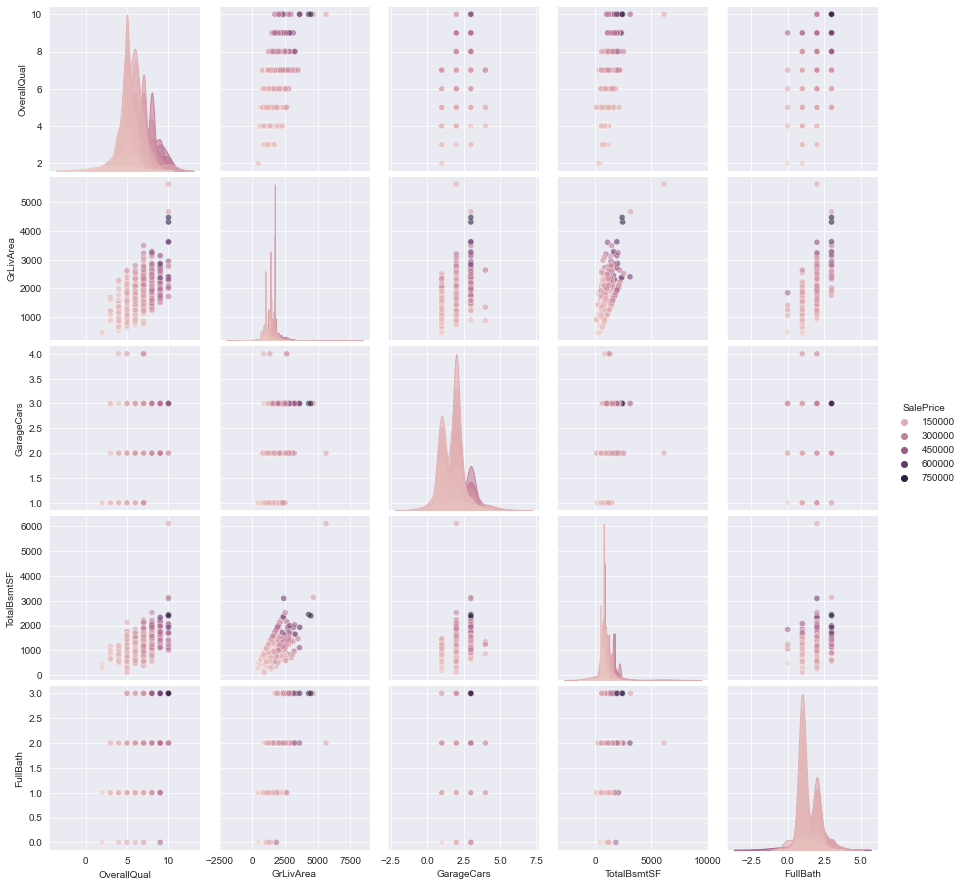

In [12]:

## plot multivariate relationships

sns.pairplot(df_train_plot[['OverallQual', 'GrLivArea', 'GarageCars', 
                            'TotalBsmtSF', 'FullBath', 
                            'SalePrice']], 
             diag_kind = 'kde', 
             hue = 'SalePrice', 
             plot_kws = {'alpha': 0.6},
             diag_kws = {'alpha': 0.6})

plt.show()

The above scatterplots display the paired relationship of the top features to the sale price. The scatterplots are ordered based on the features' correlation to the sale price (most correlated to least correlated). 

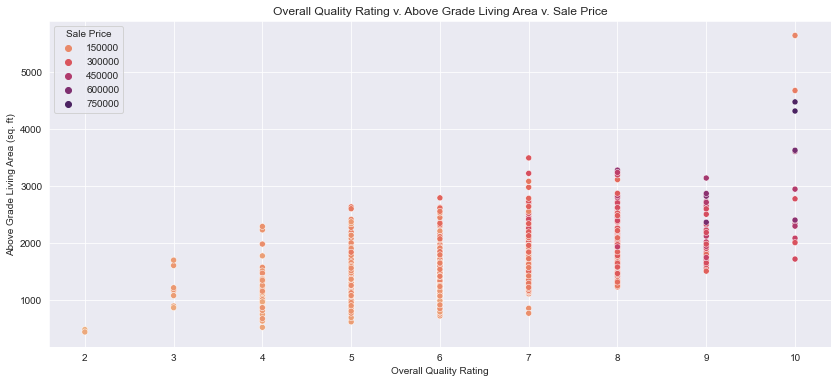

In [13]:

## potting the distribution of sales prices in relation to the above ground living area ang overall quality rating

palette = sns.color_palette('flare', as_cmap=True)

fig, ax = plt.subplots(1,1, figsize=(14,6))

ax = sns.scatterplot(
     data=df_train_plot.rename(columns={"SalePrice": "Sale Price"}),
     x="OverallQual", y="GrLivArea", hue='Sale Price', palette=palette )
ax.set_title('Overall Quality Rating v. Above Grade Living Area v. Sale Price')
ax.set_xlabel('Overall Quality Rating')
ax.set_ylabel('Above Grade Living Area (sq. ft)')

plt.show()

With the exception of a couple of outliers, quality rating and above grade living area when paired together have a strong linear relationship with sale price.

### Correlation of Variables

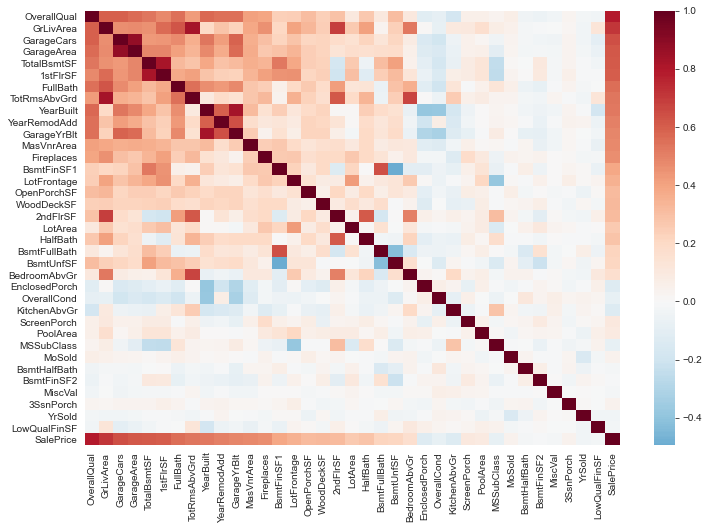

In [14]:

## Visualizing the Correlatedness of the Session variables

fig, ax = plt.subplots(figsize=(12,8))         
sns.heatmap(df_train[relationship_to_target['feature name']].corr(), cmap='RdBu_r', center=0)
plt.show()

There are strong correlations among features that measure a similar quality of the homes (such as the year the house was built and year the garage was built).

### Descriptive Statistics and Boxplots

In [15]:

## descriptive statistics of most significant features
print()
print('Descriptive Statistics of Top Features')

display(df_train_plot[relationship_to_target.sort_values(by='p-value'
                                                )['feature name'
                                                 ][:6].append(pd.Series('SalePrice'))].describe().T)


Descriptive Statistics of Top Features


,count,mean,std,min,25%,50%,75%,max
OverallQual,1094.0,6.247715,1.366797,2.0,5.0,6.0,7.0,10.0
GrLivArea,1094.0,1535.027422,526.124028,438.0,1164.0,1480.0,1779.0,5642.0
GarageCars,1094.0,1.879342,0.658586,1.0,1.0,2.0,2.0,4.0
GarageArea,1094.0,503.760512,192.261314,160.0,360.0,484.0,602.5,1418.0
TotalBsmtSF,1094.0,1099.561243,415.851262,105.0,816.0,1023.0,1345.5,6110.0
1stFlrSF,1094.0,1173.809872,387.677463,438.0,894.0,1097.0,1413.5,4692.0
SalePrice,1094.0,187033.263254,83165.332151,35311.0,132500.0,165750.0,221000.0,755000.0


Due to the prescence of outliers, the median (the colum denoted '50%') displays information that is more representative of the data.

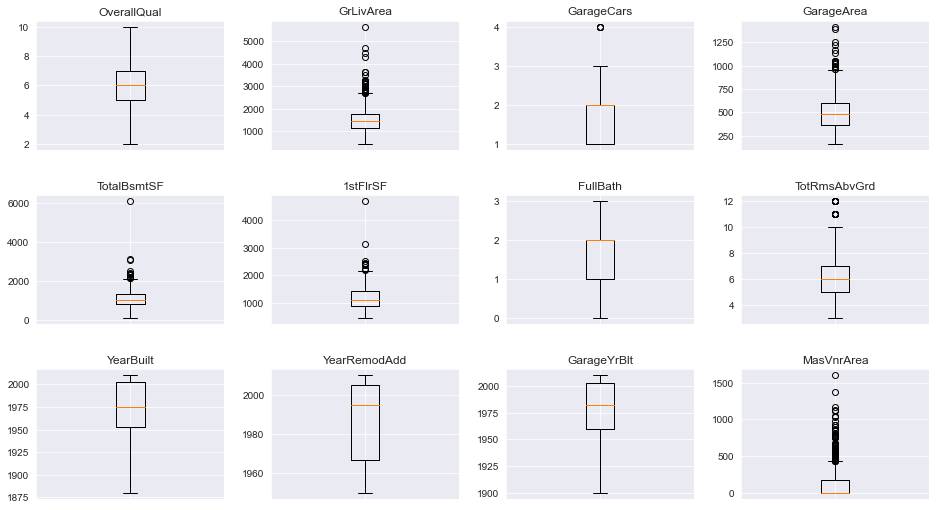

In [16]:

## visualizing the features' relationship to the target variable

# defining data to plot
df_to_plot = df_train_plot[relationship_to_target['feature name'][:12]]
target_to_plot = df_train_plot['SalePrice']

# defining plot dimensions
num_cols = 4
hspace = 0.35
wspace = 0.25
figsize = (16,12)

# plotting data
num_rows = len(df_to_plot.columns) // num_cols + 1

fig = plt.figure(figsize=figsize)
fig.subplots_adjust(hspace=hspace, wspace=wspace)

for i in range(len(df_to_plot.columns) + 1)[1:]:
    plt.subplot(num_rows, num_cols, i)
    plt.boxplot(df_train_plot[df_to_plot.columns[i-1]])
    plt.xticks([1], [''])
    plt.title(df_to_plot.columns[i-1])

These boxplots, along with all of the other visualizations, can be used to uncover outliers prior to modeling. Notable outliers can be observed in the features associated with the spatial dimensions of the homes. 

## Predictive Modeling and Evaluation

Models are evaluated by using the following metrics on the validation set: R-squared value, root mean square error, and mean absolute error. Additionally, the residuals from the validation set are plotted and analyzed.

### Data Preprocessing

In [17]:
%%time

# drop extreme outliers

df_train = df_train.loc[~((df_train['GrLivArea'] > 4000) & ( df_train['SalePrice'] < 200000))]

## Establish Feature and Outcome Variables to be Used for Modeling Based on Original Features

x = df_train.drop('SalePrice',1)
y = df_train['SalePrice']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=25)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

CPU times: user 7.78 ms, sys: 935 µs, total: 8.71 ms
Wall time: 10.3 ms


In [18]:
%%time

## data preprocessing

# feature names
feature_names_categorical = x_train[list(x_train.columns[x_train.dtypes == 'object'])].columns
feature_names_continuous = x_train[list(x_train.columns[x_train.dtypes != 'object'])].columns

# categorical pipeline
pipe_categorical = Pipeline([('categorical', categorical_features), 
                             ('impute_categorical', impute_null_categorical), 
                             ('label_categorical', label_categorical),
                             ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# continuous pipeline
pipe_continuous = Pipeline([('impute_continuous', SimpleImputer(strategy='median')),
                            ('standardscaler', StandardScaler())])

# combine feature pipelines
all_features = ColumnTransformer(transformers=[('categorical_features', 
                                                pipe_categorical, 
                                                feature_names_categorical),
                                               ('continuous_features', 
                                                pipe_continuous, 
                                                feature_names_continuous) ], remainder='drop')

CPU times: user 2.93 ms, sys: 125 µs, total: 3.05 ms
Wall time: 2.96 ms


### Lasso Regression 

#### Creating and Evaluating the Model 

In [19]:
%%time

## train and fit model

# modeling pipeline
pipe = Pipeline([('all_features', all_features), 
                 ('selectkbest', SelectKBest(score_func=f_regression)),
                 ('model', Lasso())]).fit(x_train, y_train)

# searching for best parameters
pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'selectkbest__k': [40, 50, 60, 70, 80, 90, 100], 
                                  'selectkbest__score_func': [chi2, f_regression, mutual_info_regression]}, 
                    n_jobs=-1
                   ).fit(x_train, y_train)

print()
print('Best Gridsearch Parameters')
print()
print(pipe.best_params_)

pipe = pipe.best_estimator_


Best Gridsearch Parameters

{'selectkbest__k': 60, 'selectkbest__score_func': <function mutual_info_regression at 0x1a1aaab4d0>}
CPU times: user 3.93 s, sys: 198 ms, total: 4.13 s
Wall time: 32.1 s


In [20]:
%%time

## Model Evaluation 

print('Train Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_train, y_train)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, 
                                                  x_train, 
                                                  y_train, 
                                                  cv=5)))
print()

Train Set Evaluation

R squared score:
0.9030167062841228

RMSE: 25113.36132749453

MAE: 16820.04146998192

cross validation:
[0.88363817 0.8882476  0.86559395 0.84905568 0.85664714]

CPU times: user 12.3 s, sys: 822 ms, total: 13.1 s
Wall time: 10.1 s


In [21]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_val, y_val)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.8912128919324428

RMSE: 25286.5112303519

MAE: 18205.40908267428

CPU times: user 960 ms, sys: 221 ms, total: 1.18 s
Wall time: 249 ms


In [22]:
%%time

## get coefficients 

# get feature names
one_hot_encoded_features = pipe.named_steps['all_features'
                ].named_transformers_['categorical_features'
                                     ].named_steps['one_hot'].get_feature_names()

all_feature_names = list(one_hot_encoded_features) + list(feature_names_continuous)

selected_feature_names = np.array(all_feature_names)[pipe.named_steps['selectkbest'].get_support()]

# get coefficients
linear_model_coefficients = pipe.named_steps['model'].coef_

# display coefficients
coefficient_analysis = pd.DataFrame([selected_feature_names, 
              linear_model_coefficients, 
              abs(linear_model_coefficients)]
            ).T.sort_values(2, 
                            ascending=False
                           ).rename(columns={0:"features", 
                                             1:"coefficients", 
                                             2:"absolute value coefficients"})

display(coefficient_analysis.head(10))

,features,coefficients,absolute value coefficients
9,x18_ExterQual TA,-22722.1,22722.1
20,x30_KitchenQual Ex,22487,22487
8,x18_ExterQual Gd,-19114.5,19114.5
48,2ndFlrSF,18681.2,18681.2
35,x42_SaleCondition Partial,16540.3,16540.3
49,GrLivArea,16424.2,16424.2
39,OverallQual,15412.3,15412.3
13,x21_BsmtQual Gd,-13579.8,13579.8
41,YearBuilt,12855.5,12855.5
46,TotalBsmtSF,12449.2,12449.2


CPU times: user 56.6 ms, sys: 12.4 ms, total: 69 ms
Wall time: 18.2 ms


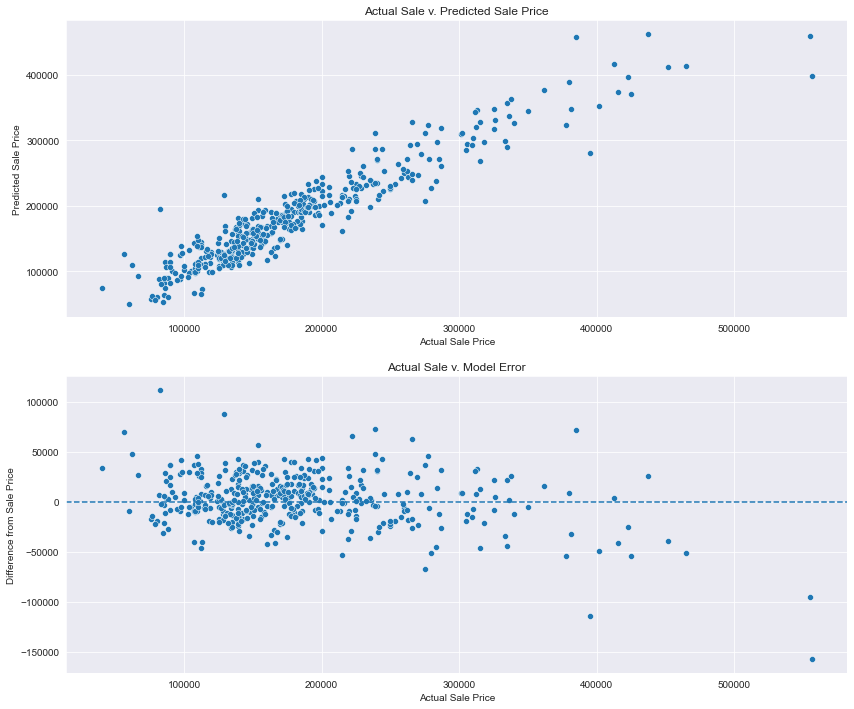

CPU times: user 1.14 s, sys: 168 ms, total: 1.3 s
Wall time: 523 ms


In [23]:
%%time

## potting the distribution of predicted and actual values

to_plot = pd.DataFrame()

to_plot['Actual'] = y_val
to_plot['Predicted'] = pipe.predict(x_val)
to_plot['Predicted - Actual'] = to_plot['Predicted'] - to_plot['Actual']


fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the predicted and actual values
plt.subplot(2, 1, 1)
ax[0] = sns.scatterplot(
     data=to_plot,
     x="Actual", y="Predicted")
ax[0].set_title('Actual Sale v. Predicted Sale Price')
ax[0].set_xlabel('Actual Sale Price')
ax[0].set_ylabel('Predicted Sale Price')

# potting the difference between the predicted and actual values
plt.subplot(2, 1, 2)
ax[1] = sns.scatterplot(
     data=to_plot,
     x="Actual", y='Predicted - Actual')
ax[1].set_title('Actual Sale v. Model Error')
ax[1].set_xlabel('Actual Sale Price')
ax[1].set_ylabel('Difference from Sale Price')
ax[1].axhline(0, ls='--')
plt.show()

### Elastic Net Regression 

#### Creating and Evaluating the Model 

In [24]:
%%time

## train and fit model

# modeling pipeline
pipe = Pipeline([('all_features', all_features), 
                 ('selectkbest', SelectKBest(score_func=f_regression)),
                 ('model', ElasticNet())]).fit(x_train, y_train)

# searching for best parameters
pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'selectkbest__k': [40, 50, 60, 70, 80, 90, 100], 
                                  'selectkbest__score_func': [chi2, f_regression, mutual_info_regression]}, 
                    n_jobs=-1
                   ).fit(x_train, y_train)

print()
print('Best Gridsearch Parameters')
print()
print(pipe.best_params_)

pipe = pipe.best_estimator_


Best Gridsearch Parameters

{'selectkbest__k': 100, 'selectkbest__score_func': <function mutual_info_regression at 0x1a1aaab4d0>}
CPU times: user 3.99 s, sys: 111 ms, total: 4.1 s
Wall time: 26.5 s


In [25]:
%%time

## Model Evaluation 

print('Train Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_train, y_train)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, 
                                                  x_train, 
                                                  y_train, 
                                                  cv=5)))
print()

Train Set Evaluation

R squared score:
0.8726996476462112

RMSE: 28772.07498179733

MAE: 17791.71625170501

cross validation:
[0.86903176 0.84563864 0.86126833 0.84040814 0.89330026]

CPU times: user 12.4 s, sys: 884 ms, total: 13.3 s
Wall time: 9.18 s


In [26]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_val, y_val)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.8770948597318916

RMSE: 26877.274170578894

MAE: 18433.712409513028

CPU times: user 956 ms, sys: 240 ms, total: 1.2 s
Wall time: 244 ms


In [27]:
%%time

## get coefficients 

# get feature names
one_hot_encoded_features = pipe.named_steps['all_features'
                ].named_transformers_['categorical_features'
                                     ].named_steps['one_hot'].get_feature_names()

all_feature_names = list(one_hot_encoded_features) + list(feature_names_continuous)

selected_feature_names = np.array(all_feature_names)[pipe.named_steps['selectkbest'].get_support()]

# get coefficients
linear_model_coefficients = pipe.named_steps['model'].coef_

# display coefficients
coefficient_analysis = pd.DataFrame([selected_feature_names, 
              linear_model_coefficients, 
              abs(linear_model_coefficients)]
            ).T.sort_values(2, 
                            ascending=False
                           ).rename(columns={0:"features", 
                                             1:"coefficients", 
                                             2:"absolute value coefficients"})

display(coefficient_analysis.head(10))

,features,coefficients,absolute value coefficients
77,OverallQual,11523.2,11523.2
87,GrLivArea,11020.7,11020.7
84,TotalBsmtSF,8419.7,8419.7
82,BsmtFinSF1,7825.94,7825.94
85,1stFlrSF,7585.91,7585.91
86,2ndFlrSF,6543.07,6543.07
81,MasVnrArea,6112.85,6112.85
33,x21_BsmtQual Ex,4767.18,4767.18
96,GarageArea,4597.65,4597.65
50,x30_KitchenQual Ex,4560.62,4560.62


CPU times: user 57.2 ms, sys: 11.8 ms, total: 69 ms
Wall time: 17.6 ms


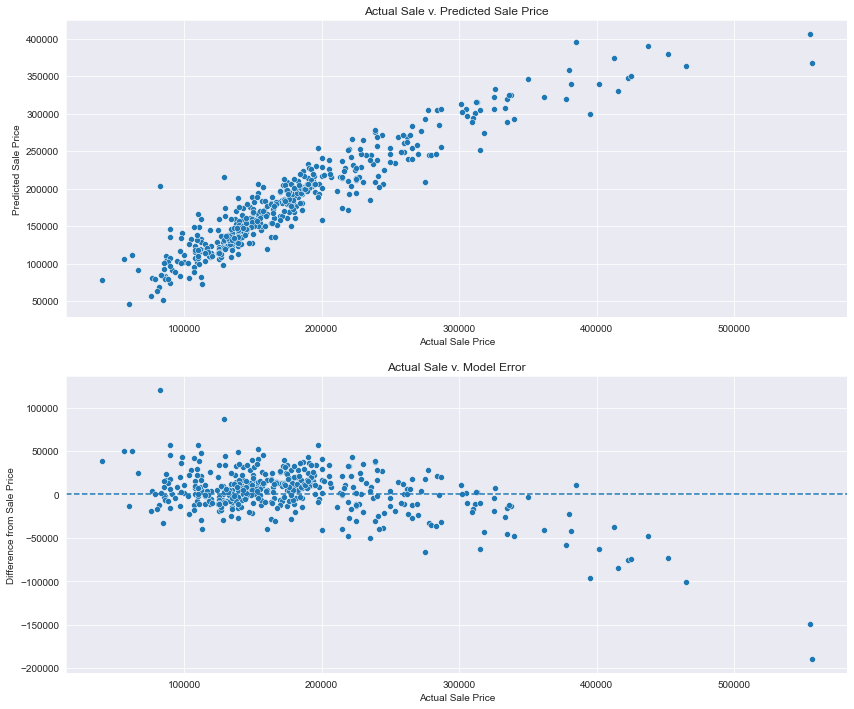

CPU times: user 1.12 s, sys: 180 ms, total: 1.3 s
Wall time: 593 ms


In [28]:
%%time

## potting the distribution of predicted and actual values

to_plot = pd.DataFrame()

to_plot['Actual'] = y_val
to_plot['Predicted'] = pipe.predict(x_val)
to_plot['Predicted - Actual'] = to_plot['Predicted'] - to_plot['Actual']


fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the predicted and actual values
plt.subplot(2, 1, 1)
ax[0] = sns.scatterplot(
     data=to_plot,
     x="Actual", y="Predicted")
ax[0].set_title('Actual Sale v. Predicted Sale Price')
ax[0].set_xlabel('Actual Sale Price')
ax[0].set_ylabel('Predicted Sale Price')

# potting the difference between the predicted and actual values
plt.subplot(2, 1, 2)
ax[1] = sns.scatterplot(
     data=to_plot,
     x="Actual", y='Predicted - Actual')
ax[1].set_title('Actual Sale v. Model Error')
ax[1].set_xlabel('Actual Sale Price')
ax[1].set_ylabel('Difference from Sale Price')
ax[1].axhline(0, ls='--')
plt.show()

### Random Forest

#### Creating and Evaluating the Model 

In [29]:
%%time

## train and fit model

# modeling pipeline
pipe = Pipeline([('all_features', all_features), 
                 ('selectkbest', SelectKBest()),
                 ('model', RandomForestRegressor())]).fit(x_train, y_train)

# searching for best parameters
pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'selectkbest__k': [40, 50, 60, 70, 80, 90, 100], 
                                  'selectkbest__score_func': [chi2, f_regression, mutual_info_regression]}, 
                    n_jobs=-1
                   ).fit(x_train, y_train)

print()
print('Best Gridsearch Parameters')
print()
print(pipe.best_params_)

pipe = pipe.best_estimator_


Best Gridsearch Parameters

{'selectkbest__k': 100, 'selectkbest__score_func': <function f_regression at 0x1a1aa91050>}
CPU times: user 3.98 s, sys: 140 ms, total: 4.12 s
Wall time: 46.4 s


In [30]:
%%time

## Model Evaluation 

print('Train Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_train, y_train)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, 
                                                  x_train, 
                                                  y_train, 
                                                  cv=5)))
print()

Train Set Evaluation

R squared score:
0.9819478954057117

RMSE: 10834.785082897995

MAE: 6781.601941176471

cross validation:
[0.90204108 0.84767395 0.88839481 0.81452727 0.90175749]

CPU times: user 7.8 s, sys: 374 ms, total: 8.17 s
Wall time: 6.41 s


In [31]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_val, y_val)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.8924138451202419

RMSE: 25146.54890323045

MAE: 17384.853812785386

CPU times: user 252 ms, sys: 7.2 ms, total: 259 ms
Wall time: 258 ms


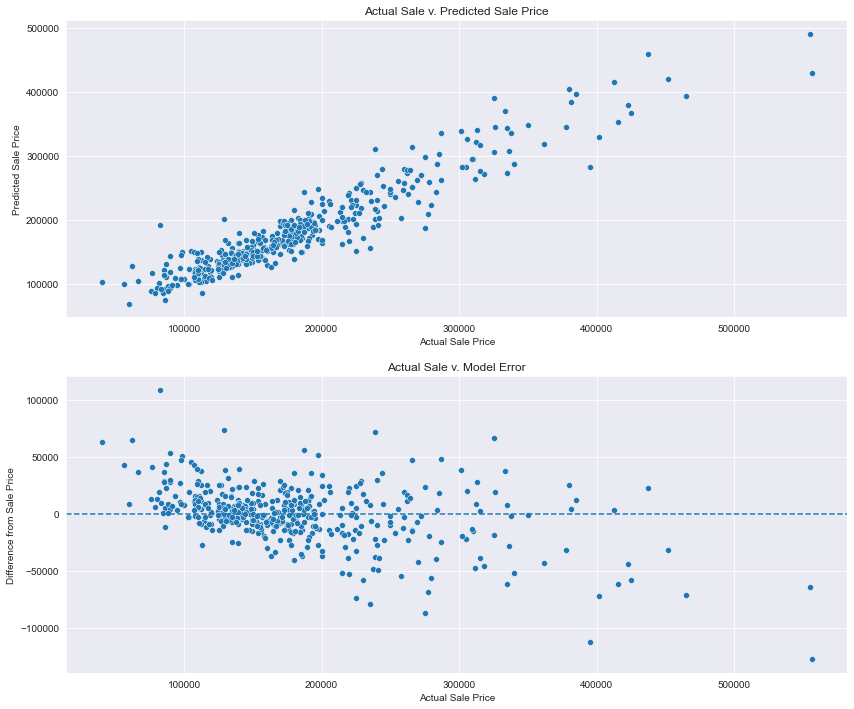

CPU times: user 667 ms, sys: 51.5 ms, total: 719 ms
Wall time: 486 ms


In [32]:
%%time

## potting the distribution of predicted and actual values

to_plot = pd.DataFrame()

to_plot['Actual'] = y_val
to_plot['Predicted'] = pipe.predict(x_val)
to_plot['Predicted - Actual'] = to_plot['Predicted'] - to_plot['Actual']


fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the predicted and actual values
plt.subplot(2, 1, 1)
ax[0] = sns.scatterplot(
     data=to_plot,
     x="Actual", y="Predicted")
ax[0].set_title('Actual Sale v. Predicted Sale Price')
ax[0].set_xlabel('Actual Sale Price')
ax[0].set_ylabel('Predicted Sale Price')

# potting the difference between the predicted and actual values
plt.subplot(2, 1, 2)
ax[1] = sns.scatterplot(
     data=to_plot,
     x="Actual", y='Predicted - Actual')
ax[1].set_title('Actual Sale v. Model Error')
ax[1].set_xlabel('Actual Sale Price')
ax[1].set_ylabel('Difference from Sale Price')
ax[1].axhline(0, ls='--')
plt.show()

### Gradient Boosting

#### Creating and Evaluating the Model 

In [33]:
%%time

## train and fit model

# modeling pipeline
pipe = Pipeline([('all_features', all_features), 
                 ('selectkbest', SelectKBest()),
                 ('model', GradientBoostingRegressor(n_estimators=300))]).fit(x_train, y_train)

# searching for best parameters
pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'selectkbest__k': [40, 50, 60, 70, 80, 90, 100], 
                                  'selectkbest__score_func': [chi2, f_regression, mutual_info_regression]}, 
                    n_jobs=-1
                   ).fit(x_train, y_train)

print()
print('Best Gridsearch Parameters')
print()
print(pipe.best_params_)

pipe = pipe.best_estimator_

top_model = pipe


Best Gridsearch Parameters

{'selectkbest__k': 40, 'selectkbest__score_func': <function mutual_info_regression at 0x1a1aaab4d0>}
CPU times: user 5.29 s, sys: 78.7 ms, total: 5.37 s
Wall time: 47.6 s


In [34]:
%%time

## Model Evaluation 

print('Train Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_train, y_train)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, 
                                                  x_train, 
                                                  y_train, 
                                                  cv=5)))
print()

Train Set Evaluation

R squared score:
0.9891345003093195

RMSE: 8405.842191538408

MAE: 6430.936983667917

cross validation:
[0.94041276 0.87946427 0.89653095 0.87107546 0.89874171]

CPU times: user 13.1 s, sys: 107 ms, total: 13.2 s
Wall time: 13.4 s


In [35]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()
print("R squared score:\n" + str(pipe.score(x_val, y_val)))
print()
print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.9172114815362296

RMSE: 22058.97119044775

MAE: 14769.614705646483

CPU times: user 198 ms, sys: 4.6 ms, total: 203 ms
Wall time: 201 ms


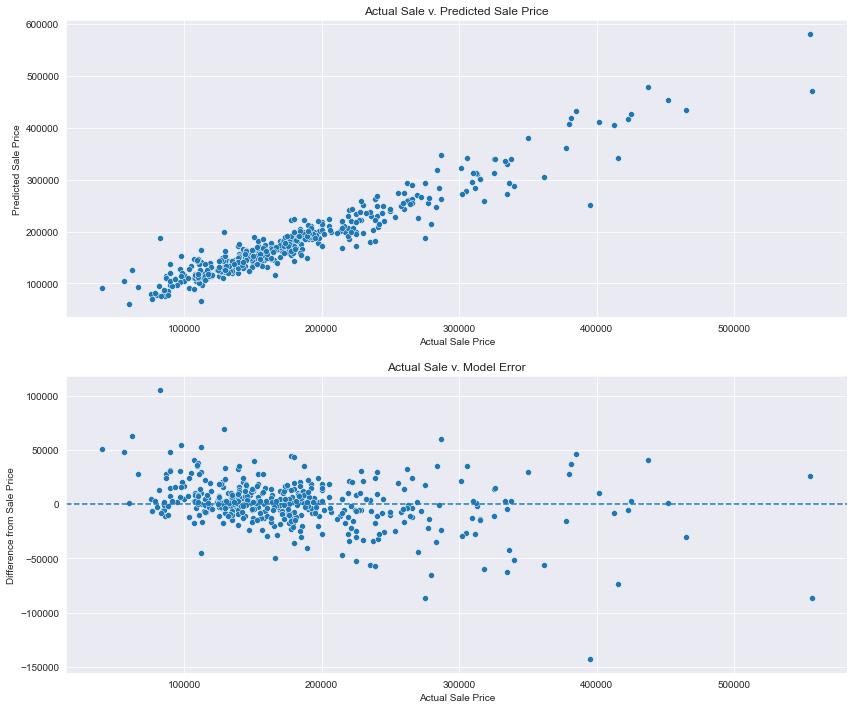

CPU times: user 668 ms, sys: 53.1 ms, total: 721 ms
Wall time: 485 ms


In [36]:
%%time

## potting the distribution of predicted and actual values

to_plot = pd.DataFrame()

to_plot['Actual'] = y_val
to_plot['Predicted'] = pipe.predict(x_val)
to_plot['Predicted - Actual'] = to_plot['Predicted'] - to_plot['Actual']


fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the predicted and actual values
plt.subplot(2, 1, 1)
ax[0] = sns.scatterplot(
     data=to_plot,
     x="Actual", y="Predicted")
ax[0].set_title('Actual Sale v. Predicted Sale Price')
ax[0].set_xlabel('Actual Sale Price')
ax[0].set_ylabel('Predicted Sale Price')

# potting the difference between the predicted and actual values
plt.subplot(2, 1, 2)
ax[1] = sns.scatterplot(
     data=to_plot,
     x="Actual", y='Predicted - Actual')
ax[1].set_title('Actual Sale v. Model Error')
ax[1].set_xlabel('Actual Sale Price')
ax[1].set_ylabel('Difference from Sale Price')
ax[1].axhline(0, ls='--')
plt.show()

The gradient boost model had the best performance out of all of the models. Cross vadidation showed fewer signs of overfitting with this model. The strength of this model when it comes to making predictions using this data comes from its ability to reduce error over multiple iterations, resulting in higher accuracy scores after a high number of iterations.

### Creating Price Predictions For Unsold Homes

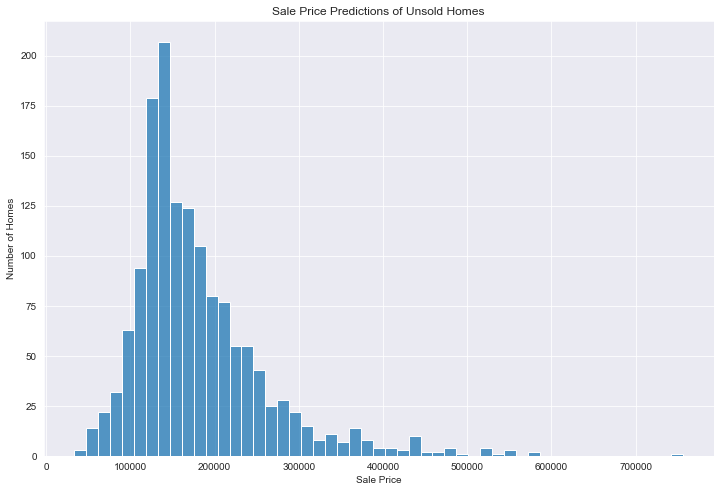

In [37]:
## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(figsize=(12,8))  
# potting the distribution of the above grade living area of the homes

ax = sns.histplot(x=top_model.predict(df_test_raw))
ax.set_title('Sale Price Predictions of Unsold Homes')
ax.set_xlabel('Sale Price')
ax.set_ylabel('Number of Homes')
plt.show()

The gradient boosting model was used to predict the sale prices of unsold homes. The predicted sale prices, have a similar distribution to the known sale prices. Most of the homes that have yet to be sold will likely be sold for around $150,000.

## Final Analysis and Conclusion

Understanding how to better utilize supervised modeling techniques to predict housing prices will give insight into which factors have the most effect on the prices of homes. Information about how such trends change over time can also be gained, which will be useful in understanding the real estate market which is a major economic indicator. 

This study established the best suprvised modeling technique for predicting housing prices. The next step in using this data to gather insights from sales of homes would be to collect housing data from greater time spans (involving similar homes) and use them to train a model that will focus on seasonality and change over time. By being able to understand how such supervised learning models can be improved with the added context of time, housing prices can be predicted even more accurately and more information can be gained about the housing market that can provide actionable insights.